In [1]:
import pandas as pd
import numpy as np
import torch.nn.functional as F
from rdkit import Chem
from rdkit.Chem import Draw
import networkx as nx
from torch_geometric.datasets import MoleculeNet
import matplotlib.pyplot as plt
from sklearn import model_selection, preprocessing, metrics, decomposition

import torch
import os
import pandas as pd
import numpy as np
import json,pickle
from collections import OrderedDict
from rdkit import Chem
from rdkit.Chem import MolFromSmiles
import networkx as nx

from torch_geometric.data import InMemoryDataset, Data
from torch_geometric.loader import DataLoader

from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm
import torch
import torch.nn as nn
import Data_Prep.Graph_Data as gd
from Data_Prep.Graph_Data import Molecule_data
from math import sqrt
from models.attenFP_v1 import AttentionConvNet
# from optuna_v1.attenFP_v1 import AttentionConvNet

In [2]:
def createFoldsData():
    iy = 0
    folds = 10
    for fold in tqdm(range(folds)):
        df_train = pd.read_csv('New_fold/fold_'+str(iy)+'_'+'x_train.csv')
        df_test  = pd.read_csv('New_fold/fold_'+str(iy)+'_'+'x_test.csv')
        smiles = df_train['SMILES']
#         codIds = df_train['CODID']
        band_gap = df_train['logS']
        band_gap = band_gap.to_numpy()

        smiles_test = df_test['SMILES']
#         codIds_test = df_test['CODID']
        band_gap_test = df_test['logS']
        band_gap_test = band_gap_test.to_numpy()


        smile_graph = {}
        band_gap_arr = []
        smiles_array = []

        for i,smile in enumerate(smiles):
            g = gd.smile_to_graph(smile)
            if g != None:
                smile_graph[smile] = g
                band_gap_arr.append(band_gap[i])
                smiles_array.append(smile)

        smile_graph_test = {}
        band_gap_arr_test = []
        smiles_array_test = []

        for i,smile in enumerate(smiles_test):
            g = gd.smile_to_graph(smile)
            if g != None:
                smile_graph_test[smile] = g
                band_gap_arr_test.append(band_gap_test[i])
                smiles_array_test.append(smile)

        train_data = Molecule_data(root='data', dataset='train_data_set_fold_'+str(iy),y=band_gap_arr,
                                   smile_graph=smile_graph,smiles=smiles_array)

        test_data = Molecule_data(root='data', dataset='test_data_set_fold_'+str(iy),y=band_gap_arr_test,
                                   smile_graph=smile_graph_test,smiles=smiles_array_test)

        iy+=1

In [3]:
df = pd.read_csv('Data_Prep/solubility_1.csv')
df = df.sample(frac=1).reset_index(drop=True)

In [4]:
smiles = df['SMILES']
# codIds = df['CODID']
band_gap = df['logS']

In [5]:
band_gap = band_gap.to_numpy()

In [6]:
def createFoldsCsv():
    from sklearn.model_selection import StratifiedKFold
    from sklearn.model_selection import KFold
    kf = KFold(n_splits=10,shuffle = True, random_state = 2) #, random_state = 2
    ix = 0
    train1 = df
    for train_index, test_index in (kf.split(train1)):
        print ("TRAIN:", len(train_index), "TEST:", len(test_index))
        X_train,X_test=train1.iloc[train_index], train1.iloc[test_index]
        X_train.to_csv('New_fold/fold_'+str(ix)+'_'+'x_train.csv',index=False)
        X_test.to_csv('New_fold/fold_'+str(ix)+'_'+'x_test.csv',index=False)
        ix+=1
    createFoldsData()

In [7]:
processed_data_file_train = 'data/processed/' + 'train_data_set_fold_'+str(0)+'.pt'
processed_data_file_test = 'data/processed/'  + 'test_data_set_fold_'+str(0)+'.pt'
if ((not os.path.isfile(processed_data_file_train)) or (not os.path.isfile(processed_data_file_test))):
        print('please run create_data.py to prepare data in pytorch format!')
        createFoldsCsv()

In [8]:
if torch.cuda.is_available():  
    device = "cuda:7"
    print("cuda:7")
else:  
    device = "cpu" 
    print(torch.cuda.is_available())

cuda:7


In [9]:
def train(model, optimizer,train_loader):
    train_labels = 0
    train_predictions = 0
    total_loss = total_examples = 0
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        out = model(data)
        # out = model(data)
        y = data.y.view([-1])
        out1 = out.view([-1])
        # print("train : ", y.shape)
        loss = F.mse_loss(out1, y)
        loss.backward()
        optimizer.step()
#         train_labels += train_labels + y
#         train_predictions += train_predictions + out1
        total_loss += float(loss) * data.num_graphs
        total_examples += data.num_graphs
    return total_loss,sqrt(total_loss / total_examples)

In [10]:
@torch.no_grad()
def test(loader, model):
    # mse = []
    model.eval()
    total_preds = torch.Tensor()
    total_labels = torch.Tensor()
    total_loss = total_examples = 0
    for data in loader:
        data = data.to(device)
        out = model(data)
        # out = model(data)
        # mse.append(F.mse_loss(out, data.y, reduction='none').cpu())
        # return float(torch.cat(mse, dim=0).mean().sqrt())
        y = data.y.view([-1])
        out1 = out.view([-1])
        # print("test : ", y.shape)
        test_loss = F.mse_loss(out1, y)
        # print("no of graphs: ", data.num_graphs)
        total_loss += float(test_loss) * data.num_graphs
        total_examples += data.num_graphs
#         total_preds = torch.cat((total_preds, out1.cpu()), 0)
#         total_labels = torch.cat((total_labels, data.y.view(-1, 1).cpu()), 0)
        # mse.append(test_loss).cpu()
    # return test_loss,float(torch.cat(mse, dim=0).mean().sqrt())
    return total_loss,sqrt(total_loss / total_examples) #,total_labels.numpy().flatten(),total_preds.numpy().flatten()

In [11]:
# Generate the model.

# optimizer = torch.optim.RMSprop(model.parameters(), lr=0.0021931604377098835,
#                                weight_decay=1.2733069489371785e-05)
the_last_loss = 100
patience = 30
trigger_times = 0
count_loss_difference = 0
#LR = 0.005
learning_rate = 0.00688267742977242
weight_decay=0.000307616688331247
#LR = 0.0028894537419258915
LOG_INTERVAL = 20
NUM_EPOCHS = 200
results = []
TRAIN_BATCH_SIZE = 64

In [12]:
best_ret = []
best_mse = 0.80
best_ci = 0
best_epoch = -1

In [13]:
folds = 10
results = []
best_rmse_arr = []
scores = []
true_val = []
pred_val = []
for fold in tqdm(range(folds)):
    model = AttentionConvNet().to(device)
    # model = define_model(trial).to(device)
    #optimizer_name = trial.suggest_categorical("optimizer", ["Adam", "RMSprop", "SGD"])
    # optimizer = torch.optim.Adam(model.parameters(), lr=.0023467,
    #                              weight_decay=.00095)
#     optimizer = torch.optim.Adam(model.parameters(), lr=0.007531829,
#                                    weight_decay=0.000252036)
#     model = AttentiveFP(in_channels=39, hidden_channels=200, out_channels=1,
#                     edge_dim=10, num_layers=2, num_timesteps=2,
#                     dropout=0.2).to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate,
                             weight_decay=weight_decay)
    val_losses = []
    train_losses = []
    mae_arr = []
    patience = 30
    trigger_times = 0
    the_last_loss = 100
    
    model_file_name = 'saved_models/model_' +  str(fold) +  '.model'
    result_file_name = 'result_' + str(fold) +  '.csv'
    
    train_data = Molecule_data(root='data', dataset='train_data_set_fold_'+str(fold),y=None,smile_graph=None,smiles=None)
    test_data = Molecule_data(root='data', dataset='test_data_set_fold_'+str(fold),y=None,smile_graph=None,smiles=None)
    model
    
    
    train_loader   = DataLoader(train_data,batch_size=TRAIN_BATCH_SIZE,shuffle=True)
    test_loader  = DataLoader(test_data,batch_size=TRAIN_BATCH_SIZE,shuffle=True)
#     model = AttentiveFP(in_channels=112, hidden_channels=279, out_channels=1,
#                     num_layers=3, num_timesteps=2,
#                     dropout=0.047352327938708194).to(device)
    best_ret = []
    
#     model = model.cuda(device)
#     optimizer = torch.optim.Adam(model.parameters(), lr=LR)
#     best_mae = 0.00
    
    for epoch in range(NUM_EPOCHS):
        train_loss,train_rmse=train(model, optimizer,train_loader)
        test_loss,test_rmse = test(test_loader, model)
#         score = metrics.r2_score(true, prediction)
#         , true, prediction
        
        print(f'Epoch: {epoch:03d}, Loss: {train_rmse:.4f} '
          f'Test: {test_rmse:.4f} ') #f'score: {score:.4f} '   
        
        ret = [epoch,train_rmse,test_rmse]
        
        train_losses.append(train_rmse)
        val_losses.append(test_rmse)
#         scores.append(score)
        # Early Stopping
        the_current_loss = test_rmse   #.item()
        best_ret.append(ret)
        if the_current_loss > the_last_loss:
            trigger_times += 1
            print('trigger times:', trigger_times)
    
            if trigger_times >= patience:
                print('Early stopping!\nStart to test process.')
                break
        else:
            ret = [epoch,train_rmse,test_rmse] #, score
            trigger_times = 0
            the_last_loss = the_current_loss
            best_rmse = the_current_loss
            
            torch.save(model.state_dict(), model_file_name)
        # Early stopping
#         the_current_loss = test_loss.item()
        
#         best_ret.append(ret)
        
#         if the_current_loss > the_last_loss:
#             trigger_times += 1
#             print('trigger times:', trigger_times)
            
#             if trigger_times >= patience:
#                 print('Early stopping!\nStart to test process.')
#                 break
#         else:
#             ret = [epoch,train_loss,test_loss.item()]
#             trigger_times = 0
#             best_mae = the_current_loss
#             the_last_loss = the_current_loss
            
#             torch.save(model.state_dict(), model_file_name)

    results.append(best_ret)
    best_rmse_arr.append(best_rmse)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 000, Loss: 1.6477 Test: 1.2105 
Epoch: 001, Loss: 1.1167 Test: 1.1868 
Epoch: 002, Loss: 1.0745 Test: 1.0472 
Epoch: 003, Loss: 1.0509 Test: 1.0757 
trigger times: 1
Epoch: 004, Loss: 1.0195 Test: 1.0265 
Epoch: 005, Loss: 0.9682 Test: 1.0433 
trigger times: 1
Epoch: 006, Loss: 0.9497 Test: 1.0018 
Epoch: 007, Loss: 0.9407 Test: 0.9886 
Epoch: 008, Loss: 0.9369 Test: 1.0868 
trigger times: 1
Epoch: 009, Loss: 0.9284 Test: 1.0373 
trigger times: 2
Epoch: 010, Loss: 0.9038 Test: 0.9890 
trigger times: 3
Epoch: 011, Loss: 0.8920 Test: 0.9967 
trigger times: 4
Epoch: 012, Loss: 0.8754 Test: 0.9489 
Epoch: 013, Loss: 0.8645 Test: 0.9752 
trigger times: 1
Epoch: 014, Loss: 0.8724 Test: 0.9524 
trigger times: 2
Epoch: 015, Loss: 0.8757 Test: 0.9486 
Epoch: 016, Loss: 0.8554 Test: 0.9256 
Epoch: 017, Loss: 0.8431 Test: 0.9528 
trigger times: 1
Epoch: 018, Loss: 0.8399 Test: 0.9502 
trigger times: 2
Epoch: 019, Loss: 0.8308 Test: 0.9616 
trigger times: 3
Epoch: 020, Loss: 0.8278 Test: 0.

Epoch: 044, Loss: 0.7601 Test: 0.8914 
trigger times: 14
Epoch: 045, Loss: 0.7554 Test: 0.8470 
Epoch: 046, Loss: 0.7761 Test: 0.8876 
trigger times: 1
Epoch: 047, Loss: 0.7711 Test: 0.9085 
trigger times: 2
Epoch: 048, Loss: 0.7686 Test: 0.8619 
trigger times: 3
Epoch: 049, Loss: 0.7542 Test: 0.9014 
trigger times: 4
Epoch: 050, Loss: 0.7351 Test: 0.8557 
trigger times: 5
Epoch: 051, Loss: 0.7242 Test: 0.8672 
trigger times: 6
Epoch: 052, Loss: 0.7242 Test: 0.8646 
trigger times: 7
Epoch: 053, Loss: 0.7349 Test: 0.8812 
trigger times: 8
Epoch: 054, Loss: 0.7192 Test: 0.8671 
trigger times: 9
Epoch: 055, Loss: 0.7726 Test: 0.8730 
trigger times: 10
Epoch: 056, Loss: 0.7490 Test: 0.8754 
trigger times: 11
Epoch: 057, Loss: 0.7576 Test: 0.8903 
trigger times: 12
Epoch: 058, Loss: 0.7388 Test: 0.8652 
trigger times: 13
Epoch: 059, Loss: 0.7264 Test: 0.8905 
trigger times: 14
Epoch: 060, Loss: 0.7025 Test: 0.8936 
trigger times: 15
Epoch: 061, Loss: 0.6914 Test: 0.8909 
trigger times: 16
E

Epoch: 061, Loss: 0.6941 Test: 0.9026 
trigger times: 21
Epoch: 062, Loss: 0.6699 Test: 0.8833 
trigger times: 22
Epoch: 063, Loss: 0.6930 Test: 0.8802 
trigger times: 23
Epoch: 064, Loss: 0.6931 Test: 0.8864 
trigger times: 24
Epoch: 065, Loss: 0.7230 Test: 0.9175 
trigger times: 25
Epoch: 066, Loss: 0.7026 Test: 0.8652 
trigger times: 26
Epoch: 067, Loss: 0.6744 Test: 0.8827 
trigger times: 27
Epoch: 068, Loss: 0.6673 Test: 0.9052 
trigger times: 28
Epoch: 069, Loss: 0.6725 Test: 0.8947 
trigger times: 29
Epoch: 070, Loss: 0.6697 Test: 0.8916 
trigger times: 30
Early stopping!
Start to test process.
Epoch: 000, Loss: 1.5652 Test: 1.2389 
Epoch: 001, Loss: 1.1063 Test: 1.1104 
Epoch: 002, Loss: 1.0546 Test: 1.2056 
trigger times: 1
Epoch: 003, Loss: 1.0177 Test: 1.0241 
Epoch: 004, Loss: 0.9829 Test: 1.1166 
trigger times: 1
Epoch: 005, Loss: 0.9945 Test: 1.0218 
Epoch: 006, Loss: 0.9486 Test: 1.0268 
trigger times: 1
Epoch: 007, Loss: 0.9407 Test: 1.0213 
Epoch: 008, Loss: 0.9197 Tes

Epoch: 012, Loss: 0.9041 Test: 1.0258 
Epoch: 013, Loss: 0.8625 Test: 1.0352 
trigger times: 1
Epoch: 014, Loss: 0.8435 Test: 1.0740 
trigger times: 2
Epoch: 015, Loss: 0.8495 Test: 1.0174 
Epoch: 016, Loss: 0.8239 Test: 1.0597 
trigger times: 1
Epoch: 017, Loss: 0.8391 Test: 1.0441 
trigger times: 2
Epoch: 018, Loss: 0.8308 Test: 1.0408 
trigger times: 3
Epoch: 019, Loss: 0.8363 Test: 1.0175 
trigger times: 4
Epoch: 020, Loss: 0.8265 Test: 1.0712 
trigger times: 5
Epoch: 021, Loss: 0.7983 Test: 1.0523 
trigger times: 6
Epoch: 022, Loss: 0.7942 Test: 1.0522 
trigger times: 7
Epoch: 023, Loss: 0.7866 Test: 1.0565 
trigger times: 8
Epoch: 024, Loss: 0.7930 Test: 1.0369 
trigger times: 9
Epoch: 025, Loss: 0.7789 Test: 1.0572 
trigger times: 10
Epoch: 026, Loss: 0.8197 Test: 1.0857 
trigger times: 11
Epoch: 027, Loss: 0.7856 Test: 1.0670 
trigger times: 12
Epoch: 028, Loss: 0.7772 Test: 1.0925 
trigger times: 13
Epoch: 029, Loss: 0.7508 Test: 1.0638 
trigger times: 14
Epoch: 030, Loss: 0.7

In [14]:
format_float = "{:.2f}".format(best_rmse)

In [15]:
type(format_float)

str

In [16]:
resSt = results[0][1]

In [17]:
res_val = resSt

In [18]:
res_val

[1, 1.116685056719285, 1.186762693000706]

58
58
50
50
97
97
37
37
71
71
52
52
77
77
46
46
53
53
61
61


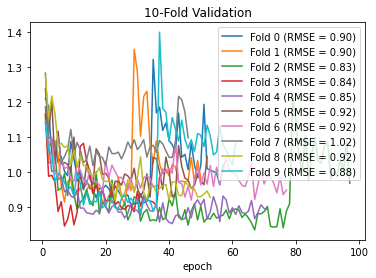

In [19]:
folds = 10
for fold in range(folds):
    train_loss_arr = []
    test_loss_arr = []
    for res in results[fold]:
        train_loss_arr.append(res[1])
        test_loss_arr.append(res[2])
    
    print(len(train_loss_arr))
    print(len(test_loss_arr))
    ax = plt.subplot(1,1,1)
    
    ax.WindowState = 'maximized';

    format_mae = "{:.2f}".format(best_rmse_arr[fold])
    
  #  ax.plot([e for e in range(1,len(train_loss_arr) + 1)], train_loss_arr, label="train_loss")
    ax.plot([e for e in range(1,len(test_loss_arr) + 1)],
            test_loss_arr, label="Fold " + str(fold) + " (RMSE = " + format_mae + ")")
    plt.xlabel("epoch")
    ax.title.set_text('10-Fold Validation')
    ax.legend()
    ax.figure.savefig('Visualization/'+str(fold)+'.png')

In [20]:
# whole data set as training dataset
def createTestData(path,filename,datasetname):
    iy = 0
#     folds = 10
#     for fold in tqdm(range(folds)):
#     df_train = pd.read_csv('New_fold/fold_'+str(iy)+'_'+'x_train.csv')
#     df_test  = pd.read_csv('New_fold/fold_'+str(iy)+'_'+'x_test.csv')
#     smiles = df_train['SMILES']
#         codIds = df_train['CODID']
#     solubility = df_train['logS']
#     solubility = solubility.to_numpy()
    df_test = pd.read_csv(path + '/' + filename)
#     df_test  = pd.read_csv('New_fold/testset_novel.csv')
    smiles_test = df_test['SMILES']
#         codIds_test = df_test['CODID']
    solubility_test = df_test['logS']
    solubility_test = solubility_test.to_numpy()


#     smile_graph = {}
#     solubility_arr = []
#     smiles_array = []
    smile_graph_test = {}
    solubility_arr_test = []
    smiles_array_test = []

    for i,smile in enumerate(smiles_test):
        g = gd.smile_to_graph(smile)
        if g != None:
            smile_graph_test[smile] = g
            solubility_arr_test.append(smiles_test[i])
            smiles_array_test.append(smile)

#     train_data = Molecule_data(root='data', dataset='train_data_set_fold_'+str(iy),y=band_gap_arr,
#                                smile_graph=smile_graph,smiles=smiles_array)

    noveltest_data = Molecule_data(root='data', dataset=datasetname,y=solubility_test,
                               smile_graph=smile_graph_test,smiles=smiles_array_test)
    return noveltest_data
#     iy+=1

In [28]:
@torch.no_grad()
def predicting(loader, model):
    total_preds = torch.Tensor()
    total_labels = torch.Tensor()
    total_loss = total_examples = 0
    for data in loader:
        data = data.to(device)
        out = model(data)
        # out = model(data)
        # mse.append(F.mse_loss(out, data.y, reduction='none').cpu())
        # return float(torch.cat(mse, dim=0).mean().sqrt())
        y = data.y.view([-1])
        out1 = out.view([-1])
        # print("test : ", y.shape)
        test_loss = F.mse_loss(out1, y)
        # print("no of graphs: ", data.num_graphs)
        total_loss += float(test_loss) * data.num_graphs
        total_examples += data.num_graphs
        total_preds = torch.cat((total_preds, out.view(-1, 1).cpu()), 0)
        total_labels = torch.cat((total_labels, data.y.view(-1, 1).cpu()), 0)
        print("total_labels : ", total_labels.shape)
        print("total_preds : ", total_preds.shape)
        # mse.append(test_loss).cpu()
    # return test_loss,float(torch.cat(mse, dim=0).mean().sqrt())
    return total_loss,sqrt(total_loss / total_examples),total_labels.numpy().flatten(),total_preds.numpy().flatten()

  0%|          | 0/10 [00:00<?, ?it/s]

total_labels :  tensor([[-4.1727e+00],
        [-6.4284e+00],
        [-3.6591e+00],
        [-4.8500e+00],
        [-7.2000e-01],
        [-1.9139e+00],
        [-1.7014e+00],
        [-4.0008e+00],
        [-3.6964e+00],
        [-3.3757e+00],
        [-7.5337e+00],
        [-8.2265e-01],
        [-5.6027e+00],
        [ 2.8545e-01],
        [-2.7390e+00],
        [-3.8182e+00],
        [-2.3613e+00],
        [-3.9050e+00],
        [-3.8640e+00],
        [-9.5727e-01],
        [-5.2200e+00],
        [-3.9700e+00],
        [-2.8000e-01],
        [-3.0105e-01],
        [-5.6000e+00],
        [-4.4491e+00],
        [ 3.4417e-02],
        [-2.4600e+00],
        [ 2.0591e-03],
        [-1.0265e+00],
        [-3.4875e+00],
        [-1.7239e+00],
        [-3.1300e+00],
        [-3.7329e+00],
        [-1.2797e+00],
        [-1.1047e+00],
        [-2.1212e+00],
        [-2.9423e+00],
        [-2.1742e+00],
        [-8.3000e-01],
        [-6.4967e-01],
        [-1.6274e+00],
        [-2.8090e+

total_labels :  tensor([[-4.1727e+00],
        [-6.4284e+00],
        [-3.6591e+00],
        [-4.8500e+00],
        [-7.2000e-01],
        [-1.9139e+00],
        [-1.7014e+00],
        [-4.0008e+00],
        [-3.6964e+00],
        [-3.3757e+00],
        [-7.5337e+00],
        [-8.2265e-01],
        [-5.6027e+00],
        [ 2.8545e-01],
        [-2.7390e+00],
        [-3.8182e+00],
        [-2.3613e+00],
        [-3.9050e+00],
        [-3.8640e+00],
        [-9.5727e-01],
        [-5.2200e+00],
        [-3.9700e+00],
        [-2.8000e-01],
        [-3.0105e-01],
        [-5.6000e+00],
        [-4.4491e+00],
        [ 3.4417e-02],
        [-2.4600e+00],
        [ 2.0591e-03],
        [-1.0265e+00],
        [-3.4875e+00],
        [-1.7239e+00],
        [-3.1300e+00],
        [-3.7329e+00],
        [-1.2797e+00],
        [-1.1047e+00],
        [-2.1212e+00],
        [-2.9423e+00],
        [-2.1742e+00],
        [-8.3000e-01],
        [-6.4967e-01],
        [-1.6274e+00],
        [-2.8090e+

total_labels :  tensor([[-4.1727e+00],
        [-6.4284e+00],
        [-3.6591e+00],
        [-4.8500e+00],
        [-7.2000e-01],
        [-1.9139e+00],
        [-1.7014e+00],
        [-4.0008e+00],
        [-3.6964e+00],
        [-3.3757e+00],
        [-7.5337e+00],
        [-8.2265e-01],
        [-5.6027e+00],
        [ 2.8545e-01],
        [-2.7390e+00],
        [-3.8182e+00],
        [-2.3613e+00],
        [-3.9050e+00],
        [-3.8640e+00],
        [-9.5727e-01],
        [-5.2200e+00],
        [-3.9700e+00],
        [-2.8000e-01],
        [-3.0105e-01],
        [-5.6000e+00],
        [-4.4491e+00],
        [ 3.4417e-02],
        [-2.4600e+00],
        [ 2.0591e-03],
        [-1.0265e+00],
        [-3.4875e+00],
        [-1.7239e+00],
        [-3.1300e+00],
        [-3.7329e+00],
        [-1.2797e+00],
        [-1.1047e+00],
        [-2.1212e+00],
        [-2.9423e+00],
        [-2.1742e+00],
        [-8.3000e-01],
        [-6.4967e-01],
        [-1.6274e+00],
        [-2.8090e+

total_labels :  tensor([[-4.1727e+00],
        [-6.4284e+00],
        [-3.6591e+00],
        [-4.8500e+00],
        [-7.2000e-01],
        [-1.9139e+00],
        [-1.7014e+00],
        [-4.0008e+00],
        [-3.6964e+00],
        [-3.3757e+00],
        [-7.5337e+00],
        [-8.2265e-01],
        [-5.6027e+00],
        [ 2.8545e-01],
        [-2.7390e+00],
        [-3.8182e+00],
        [-2.3613e+00],
        [-3.9050e+00],
        [-3.8640e+00],
        [-9.5727e-01],
        [-5.2200e+00],
        [-3.9700e+00],
        [-2.8000e-01],
        [-3.0105e-01],
        [-5.6000e+00],
        [-4.4491e+00],
        [ 3.4417e-02],
        [-2.4600e+00],
        [ 2.0591e-03],
        [-1.0265e+00],
        [-3.4875e+00],
        [-1.7239e+00],
        [-3.1300e+00],
        [-3.7329e+00],
        [-1.2797e+00],
        [-1.1047e+00],
        [-2.1212e+00],
        [-2.9423e+00],
        [-2.1742e+00],
        [-8.3000e-01],
        [-6.4967e-01],
        [-1.6274e+00],
        [-2.8090e+

total_labels :  tensor([[ -7.2000],
        [ -1.4722],
        [-13.6194],
        [ -0.9100],
        [ -1.0500],
        [ -2.9494],
        [  0.3134],
        [ -3.9571],
        [ -4.4658],
        [ -0.7700],
        [ -0.8616],
        [ -3.5800],
        [  0.3114],
        [ -3.8006],
        [ -2.5290],
        [ -3.7286],
        [ -3.0159],
        [ -3.0800],
        [  0.1105],
        [ -3.3806],
        [ -1.2036],
        [  0.3765],
        [ -3.1058],
        [ -3.6906],
        [ -4.4691],
        [ -2.3919],
        [ -2.6749],
        [ -3.9748],
        [ -1.1236],
        [ -3.9610],
        [ -3.8544],
        [ -1.8506],
        [ -1.1309],
        [ -0.4687],
        [ -4.0471],
        [ -1.3522],
        [ -2.0274],
        [ -1.1402],
        [ -2.1532],
        [ -4.8700],
        [ -4.0134],
        [ -2.9800],
        [ -3.6400],
        [ -2.2200],
        [ -9.9746],
        [ -2.3754],
        [ -4.3155],
        [ -2.4333],
        [ -2.0944],
    

total_labels :  tensor([[ -7.2000],
        [ -1.4722],
        [-13.6194],
        [ -0.9100],
        [ -1.0500],
        [ -2.9494],
        [  0.3134],
        [ -3.9571],
        [ -4.4658],
        [ -0.7700],
        [ -0.8616],
        [ -3.5800],
        [  0.3114],
        [ -3.8006],
        [ -2.5290],
        [ -3.7286],
        [ -3.0159],
        [ -3.0800],
        [  0.1105],
        [ -3.3806],
        [ -1.2036],
        [  0.3765],
        [ -3.1058],
        [ -3.6906],
        [ -4.4691],
        [ -2.3919],
        [ -2.6749],
        [ -3.9748],
        [ -1.1236],
        [ -3.9610],
        [ -3.8544],
        [ -1.8506],
        [ -1.1309],
        [ -0.4687],
        [ -4.0471],
        [ -1.3522],
        [ -2.0274],
        [ -1.1402],
        [ -2.1532],
        [ -4.8700],
        [ -4.0134],
        [ -2.9800],
        [ -3.6400],
        [ -2.2200],
        [ -9.9746],
        [ -2.3754],
        [ -4.3155],
        [ -2.4333],
        [ -2.0944],
    

total_labels :  tensor([[-7.2000e+00],
        [-1.4722e+00],
        [-1.3619e+01],
        [-9.1000e-01],
        [-1.0500e+00],
        [-2.9494e+00],
        [ 3.1341e-01],
        [-3.9571e+00],
        [-4.4658e+00],
        [-7.7000e-01],
        [-8.6156e-01],
        [-3.5800e+00],
        [ 3.1135e-01],
        [-3.8006e+00],
        [-2.5290e+00],
        [-3.7286e+00],
        [-3.0159e+00],
        [-3.0800e+00],
        [ 1.1048e-01],
        [-3.3806e+00],
        [-1.2036e+00],
        [ 3.7651e-01],
        [-3.1058e+00],
        [-3.6906e+00],
        [-4.4691e+00],
        [-2.3919e+00],
        [-2.6749e+00],
        [-3.9748e+00],
        [-1.1236e+00],
        [-3.9610e+00],
        [-3.8544e+00],
        [-1.8506e+00],
        [-1.1309e+00],
        [-4.6870e-01],
        [-4.0471e+00],
        [-1.3522e+00],
        [-2.0274e+00],
        [-1.1402e+00],
        [-2.1532e+00],
        [-4.8700e+00],
        [-4.0134e+00],
        [-2.9800e+00],
        [-3.6400e+

total_labels :  tensor([[ -2.1432],
        [  0.6400],
        [ -2.0230],
        [ -2.4412],
        [ -3.2033],
        [ -4.8872],
        [ -1.5635],
        [ -1.3915],
        [ -0.8900],
        [ -4.5523],
        [ -3.0892],
        [ -0.9401],
        [ -2.4743],
        [ -5.1600],
        [ -2.4835],
        [ -3.4146],
        [-10.0100],
        [ -0.5792],
        [ -1.7528],
        [ -2.6200],
        [ -8.6000],
        [ -4.1376],
        [ -2.9395],
        [ -4.2189],
        [ -4.6340],
        [ -3.6749],
        [ -1.2300],
        [ -3.6994],
        [ -2.8522],
        [ -1.6136],
        [ -3.4082],
        [ -0.9939],
        [ -2.5589],
        [ -3.9611],
        [ -1.3000],
        [ -4.5324],
        [ -2.0513],
        [ -0.8562],
        [  0.2115],
        [ -2.5314],
        [ -2.6852],
        [ -2.2400],
        [ -2.9563],
        [ -2.6500],
        [  0.2738],
        [ -3.2779],
        [ -2.2200],
        [ -3.1738],
        [ -2.3643],
    

total_labels :  tensor([[-2.1432e+00],
        [ 6.4000e-01],
        [-2.0230e+00],
        [-2.4412e+00],
        [-3.2033e+00],
        [-4.8872e+00],
        [-1.5635e+00],
        [-1.3915e+00],
        [-8.9000e-01],
        [-4.5523e+00],
        [-3.0892e+00],
        [-9.4008e-01],
        [-2.4743e+00],
        [-5.1600e+00],
        [-2.4835e+00],
        [-3.4146e+00],
        [-1.0010e+01],
        [-5.7924e-01],
        [-1.7528e+00],
        [-2.6200e+00],
        [-8.6000e+00],
        [-4.1376e+00],
        [-2.9395e+00],
        [-4.2189e+00],
        [-4.6340e+00],
        [-3.6749e+00],
        [-1.2300e+00],
        [-3.6994e+00],
        [-2.8522e+00],
        [-1.6136e+00],
        [-3.4082e+00],
        [-9.9389e-01],
        [-2.5589e+00],
        [-3.9611e+00],
        [-1.3000e+00],
        [-4.5324e+00],
        [-2.0513e+00],
        [-8.5617e-01],
        [ 2.1149e-01],
        [-2.5314e+00],
        [-2.6852e+00],
        [-2.2400e+00],
        [-2.9563e+

total_labels :  tensor([[-2.1432e+00],
        [ 6.4000e-01],
        [-2.0230e+00],
        [-2.4412e+00],
        [-3.2033e+00],
        [-4.8872e+00],
        [-1.5635e+00],
        [-1.3915e+00],
        [-8.9000e-01],
        [-4.5523e+00],
        [-3.0892e+00],
        [-9.4008e-01],
        [-2.4743e+00],
        [-5.1600e+00],
        [-2.4835e+00],
        [-3.4146e+00],
        [-1.0010e+01],
        [-5.7924e-01],
        [-1.7528e+00],
        [-2.6200e+00],
        [-8.6000e+00],
        [-4.1376e+00],
        [-2.9395e+00],
        [-4.2189e+00],
        [-4.6340e+00],
        [-3.6749e+00],
        [-1.2300e+00],
        [-3.6994e+00],
        [-2.8522e+00],
        [-1.6136e+00],
        [-3.4082e+00],
        [-9.9389e-01],
        [-2.5589e+00],
        [-3.9611e+00],
        [-1.3000e+00],
        [-4.5324e+00],
        [-2.0513e+00],
        [-8.5617e-01],
        [ 2.1149e-01],
        [-2.5314e+00],
        [-2.6852e+00],
        [-2.2400e+00],
        [-2.9563e+

total_labels :  tensor([[-3.2478],
        [-2.6038],
        [-2.0418],
        [ 0.1765],
        [-0.7866],
        [-2.9300],
        [-2.3900],
        [-0.8443],
        [-2.0346],
        [-3.5391],
        [-3.9885],
        [-7.5567],
        [ 0.6563],
        [-8.0200],
        [-2.6855],
        [-5.8948],
        [-4.6888],
        [-2.4857],
        [-3.0851],
        [-0.6717],
        [-0.8000],
        [-2.8815],
        [-5.2774],
        [-3.4647],
        [-4.4601],
        [-4.8806],
        [-3.2200],
        [-2.7557],
        [-2.1000],
        [-6.0768],
        [-3.0486],
        [-1.4627],
        [-1.7257],
        [-3.6289],
        [-3.7544],
        [-2.1700],
        [-2.8190],
        [-3.6905],
        [ 0.3032],
        [-2.5053],
        [-3.2100],
        [-6.0509],
        [ 0.5245],
        [-3.8664],
        [-0.8372],
        [-3.5001],
        [ 0.2515],
        [-4.9401],
        [-1.1100],
        [-3.6744],
        [-2.7638],
        [-1.340

total_labels :  tensor([[-3.2478e+00],
        [-2.6038e+00],
        [-2.0418e+00],
        [ 1.7653e-01],
        [-7.8659e-01],
        [-2.9300e+00],
        [-2.3900e+00],
        [-8.4432e-01],
        [-2.0346e+00],
        [-3.5391e+00],
        [-3.9885e+00],
        [-7.5567e+00],
        [ 6.5630e-01],
        [-8.0200e+00],
        [-2.6855e+00],
        [-5.8948e+00],
        [-4.6888e+00],
        [-2.4857e+00],
        [-3.0851e+00],
        [-6.7172e-01],
        [-8.0000e-01],
        [-2.8815e+00],
        [-5.2774e+00],
        [-3.4647e+00],
        [-4.4601e+00],
        [-4.8806e+00],
        [-3.2200e+00],
        [-2.7557e+00],
        [-2.1000e+00],
        [-6.0768e+00],
        [-3.0486e+00],
        [-1.4627e+00],
        [-1.7257e+00],
        [-3.6289e+00],
        [-3.7544e+00],
        [-2.1700e+00],
        [-2.8190e+00],
        [-3.6905e+00],
        [ 3.0321e-01],
        [-2.5053e+00],
        [-3.2100e+00],
        [-6.0509e+00],
        [ 5.2450e-

total_labels :  tensor([[-3.2478e+00],
        [-2.6038e+00],
        [-2.0418e+00],
        [ 1.7653e-01],
        [-7.8659e-01],
        [-2.9300e+00],
        [-2.3900e+00],
        [-8.4432e-01],
        [-2.0346e+00],
        [-3.5391e+00],
        [-3.9885e+00],
        [-7.5567e+00],
        [ 6.5630e-01],
        [-8.0200e+00],
        [-2.6855e+00],
        [-5.8948e+00],
        [-4.6888e+00],
        [-2.4857e+00],
        [-3.0851e+00],
        [-6.7172e-01],
        [-8.0000e-01],
        [-2.8815e+00],
        [-5.2774e+00],
        [-3.4647e+00],
        [-4.4601e+00],
        [-4.8806e+00],
        [-3.2200e+00],
        [-2.7557e+00],
        [-2.1000e+00],
        [-6.0768e+00],
        [-3.0486e+00],
        [-1.4627e+00],
        [-1.7257e+00],
        [-3.6289e+00],
        [-3.7544e+00],
        [-2.1700e+00],
        [-2.8190e+00],
        [-3.6905e+00],
        [ 3.0321e-01],
        [-2.5053e+00],
        [-3.2100e+00],
        [-6.0509e+00],
        [ 5.2450e-

total_labels :  tensor([[  0.2922],
        [  0.5930],
        [ -1.7600],
        [ -2.0600],
        [ -3.3242],
        [ -0.4451],
        [-12.0011],
        [  0.0785],
        [ -3.5530],
        [ -3.8034],
        [ -1.0569],
        [ -3.3131],
        [ -0.0194],
        [ -6.8857],
        [ -1.4198],
        [ -3.6342],
        [ -4.5602],
        [ -0.8213],
        [ -4.2396],
        [ -1.2198],
        [ -0.3146],
        [ -3.1100],
        [ -5.2000],
        [ -2.4300],
        [ -6.0100],
        [ -0.7200],
        [ -5.8166],
        [ -4.3200],
        [ -2.0700],
        [ -3.1582],
        [ -2.6010],
        [ -5.7961],
        [ -6.5509],
        [-14.5239],
        [ -4.9629],
        [ -4.7638],
        [ -1.4076],
        [ -3.3850],
        [ -8.5803],
        [ -0.6915],
        [ -2.6286],
        [ -1.8768],
        [ -2.3356],
        [ -2.4100],
        [ -4.5878],
        [ -1.9900],
        [ -2.8339],
        [  0.4735],
        [ -1.6961],
    

total_preds :  tensor([  0.2461,   0.0194,  -2.6436,  -4.5663,  -3.7004,  -1.2566, -11.1095,
         -1.4108,  -3.2066,  -2.3438,  -1.1262,  -3.4395,  -2.2702,  -8.4672,
         -2.1476,  -3.7449,  -4.9226,  -2.2791,  -3.3821,  -0.8599,  -4.8203,
         -4.2880,  -3.4073,  -2.2946,  -5.8025,  -0.9717,  -7.1395,  -4.9341,
         -1.1935,  -5.4991,  -3.2769,  -7.5206,  -8.6558, -13.7784,  -5.9533,
         -3.8976,  -4.9078,  -3.9638,  -6.9213,  -0.9811,  -4.8615,  -2.7496,
         -2.5269,  -2.4865,  -2.8921,  -1.3746,  -4.8426,   0.3449,  -1.3272,
         -4.0690,  -2.5322,  -1.7852,  -2.4073,  -3.0715,  -1.9592,  -1.0149,
         -3.1103,  -2.3720,  -5.3357,  -0.9589,  -0.8000,  -2.8817,  -6.7884,
         -1.6650,   0.2300,  -5.5058,  -1.8093,  -3.5802,  -0.3940,  -4.3682,
         -2.0707,  -2.0080,  -7.5791,  -1.5666,  -3.1383,  -2.1920,  -1.3300,
         -7.7636,  -3.0208,  -4.2472,  -3.1102,  -0.7009,  -3.6819,  -2.8146,
         -3.8479,  -7.5147,  -2.7990,  -3.7439,  

total_labels :  tensor([[ 2.9219e-01],
        [ 5.9300e-01],
        [-1.7600e+00],
        [-2.0600e+00],
        [-3.3242e+00],
        [-4.4514e-01],
        [-1.2001e+01],
        [ 7.8525e-02],
        [-3.5530e+00],
        [-3.8034e+00],
        [-1.0569e+00],
        [-3.3131e+00],
        [-1.9362e-02],
        [-6.8857e+00],
        [-1.4198e+00],
        [-3.6342e+00],
        [-4.5602e+00],
        [-8.2129e-01],
        [-4.2396e+00],
        [-1.2198e+00],
        [-3.1460e-01],
        [-3.1100e+00],
        [-5.2000e+00],
        [-2.4300e+00],
        [-6.0100e+00],
        [-7.2000e-01],
        [-5.8166e+00],
        [-4.3200e+00],
        [-2.0700e+00],
        [-3.1582e+00],
        [-2.6010e+00],
        [-5.7961e+00],
        [-6.5509e+00],
        [-1.4524e+01],
        [-4.9629e+00],
        [-4.7638e+00],
        [-1.4076e+00],
        [-3.3850e+00],
        [-8.5803e+00],
        [-6.9146e-01],
        [-2.6286e+00],
        [-1.8768e+00],
        [-2.3356e+

total_labels :  tensor([[ -3.6964],
        [ -6.8354],
        [ -6.6862],
        [ -0.7243],
        [ -4.7400],
        [ -5.9123],
        [  0.6380],
        [ -4.1912],
        [ -2.1459],
        [  0.9278],
        [  0.4947],
        [ -5.2945],
        [ -7.8433],
        [ -4.9261],
        [ -6.3400],
        [ -1.1408],
        [  0.6113],
        [ -6.9000],
        [ -4.2600],
        [ -2.5100],
        [ -7.2945],
        [ -7.0603],
        [ -1.5802],
        [ -4.4420],
        [ -2.5388],
        [ -1.4888],
        [ -2.4171],
        [ -1.1538],
        [ -0.1551],
        [ -4.3542],
        [ -2.5464],
        [ -5.7267],
        [ -3.7685],
        [ -2.7688],
        [ -2.5400],
        [  0.5400],
        [ -3.3746],
        [ -4.4870],
        [ -6.5356],
        [ -2.9569],
        [ -2.0563],
        [ -1.3000],
        [ -3.0663],
        [ -5.3544],
        [ -4.0686],
        [ -2.4155],
        [ -5.1286],
        [  0.0754],
        [ -2.3264],
    

total_labels :  tensor([[ -3.6964],
        [ -6.8354],
        [ -6.6862],
        [ -0.7243],
        [ -4.7400],
        [ -5.9123],
        [  0.6380],
        [ -4.1912],
        [ -2.1459],
        [  0.9278],
        [  0.4947],
        [ -5.2945],
        [ -7.8433],
        [ -4.9261],
        [ -6.3400],
        [ -1.1408],
        [  0.6113],
        [ -6.9000],
        [ -4.2600],
        [ -2.5100],
        [ -7.2945],
        [ -7.0603],
        [ -1.5802],
        [ -4.4420],
        [ -2.5388],
        [ -1.4888],
        [ -2.4171],
        [ -1.1538],
        [ -0.1551],
        [ -4.3542],
        [ -2.5464],
        [ -5.7267],
        [ -3.7685],
        [ -2.7688],
        [ -2.5400],
        [  0.5400],
        [ -3.3746],
        [ -4.4870],
        [ -6.5356],
        [ -2.9569],
        [ -2.0563],
        [ -1.3000],
        [ -3.0663],
        [ -5.3544],
        [ -4.0686],
        [ -2.4155],
        [ -5.1286],
        [  0.0754],
        [ -2.3264],
    

total_labels :  tensor([[ -3.6964],
        [ -6.8354],
        [ -6.6862],
        [ -0.7243],
        [ -4.7400],
        [ -5.9123],
        [  0.6380],
        [ -4.1912],
        [ -2.1459],
        [  0.9278],
        [  0.4947],
        [ -5.2945],
        [ -7.8433],
        [ -4.9261],
        [ -6.3400],
        [ -1.1408],
        [  0.6113],
        [ -6.9000],
        [ -4.2600],
        [ -2.5100],
        [ -7.2945],
        [ -7.0603],
        [ -1.5802],
        [ -4.4420],
        [ -2.5388],
        [ -1.4888],
        [ -2.4171],
        [ -1.1538],
        [ -0.1551],
        [ -4.3542],
        [ -2.5464],
        [ -5.7267],
        [ -3.7685],
        [ -2.7688],
        [ -2.5400],
        [  0.5400],
        [ -3.3746],
        [ -4.4870],
        [ -6.5356],
        [ -2.9569],
        [ -2.0563],
        [ -1.3000],
        [ -3.0663],
        [ -5.3544],
        [ -4.0686],
        [ -2.4155],
        [ -5.1286],
        [  0.0754],
        [ -2.3264],
    

total_labels :  tensor([[  0.3702],
        [ -0.8627],
        [ -1.3440],
        [  0.5847],
        [  0.3132],
        [ -3.6614],
        [ -4.9408],
        [  0.4879],
        [ -6.1703],
        [-11.5310],
        [ -2.3634],
        [ -1.2196],
        [ -1.8253],
        [ -4.8994],
        [ -1.9435],
        [ -2.5983],
        [ -0.7794],
        [ -4.2855],
        [ -2.3127],
        [ -2.4400],
        [ -2.4062],
        [ -7.8245],
        [ -3.5943],
        [ -1.9277],
        [ -3.9422],
        [ -5.4700],
        [ -4.6727],
        [ -1.0871],
        [ -4.8300],
        [ -4.1722],
        [ -3.0966],
        [ -4.0935],
        [  0.2610],
        [ -4.5217],
        [ -1.1232],
        [ -5.9000],
        [ -0.9236],
        [ -5.7779],
        [ -1.8144],
        [ -3.0190],
        [ -2.5800],
        [ -3.7568],
        [ -4.6073],
        [ -5.7985],
        [ -0.7881],
        [ -2.2889],
        [ -1.1927],
        [ -1.4819],
        [ -6.0921],
    

total_labels :  tensor([[ 3.7025e-01],
        [-8.6268e-01],
        [-1.3440e+00],
        [ 5.8473e-01],
        [ 3.1317e-01],
        [-3.6614e+00],
        [-4.9408e+00],
        [ 4.8786e-01],
        [-6.1703e+00],
        [-1.1531e+01],
        [-2.3634e+00],
        [-1.2196e+00],
        [-1.8253e+00],
        [-4.8994e+00],
        [-1.9435e+00],
        [-2.5983e+00],
        [-7.7937e-01],
        [-4.2855e+00],
        [-2.3127e+00],
        [-2.4400e+00],
        [-2.4062e+00],
        [-7.8245e+00],
        [-3.5943e+00],
        [-1.9277e+00],
        [-3.9422e+00],
        [-5.4700e+00],
        [-4.6727e+00],
        [-1.0871e+00],
        [-4.8300e+00],
        [-4.1722e+00],
        [-3.0966e+00],
        [-4.0935e+00],
        [ 2.6099e-01],
        [-4.5217e+00],
        [-1.1232e+00],
        [-5.9000e+00],
        [-9.2363e-01],
        [-5.7779e+00],
        [-1.8144e+00],
        [-3.0190e+00],
        [-2.5800e+00],
        [-3.7568e+00],
        [-4.6073e+

total_labels :  tensor([[ 3.7025e-01],
        [-8.6268e-01],
        [-1.3440e+00],
        [ 5.8473e-01],
        [ 3.1317e-01],
        [-3.6614e+00],
        [-4.9408e+00],
        [ 4.8786e-01],
        [-6.1703e+00],
        [-1.1531e+01],
        [-2.3634e+00],
        [-1.2196e+00],
        [-1.8253e+00],
        [-4.8994e+00],
        [-1.9435e+00],
        [-2.5983e+00],
        [-7.7937e-01],
        [-4.2855e+00],
        [-2.3127e+00],
        [-2.4400e+00],
        [-2.4062e+00],
        [-7.8245e+00],
        [-3.5943e+00],
        [-1.9277e+00],
        [-3.9422e+00],
        [-5.4700e+00],
        [-4.6727e+00],
        [-1.0871e+00],
        [-4.8300e+00],
        [-4.1722e+00],
        [-3.0966e+00],
        [-4.0935e+00],
        [ 2.6099e-01],
        [-4.5217e+00],
        [-1.1232e+00],
        [-5.9000e+00],
        [-9.2363e-01],
        [-5.7779e+00],
        [-1.8144e+00],
        [-3.0190e+00],
        [-2.5800e+00],
        [-3.7568e+00],
        [-4.6073e+

total_labels :  tensor([[-1.4205],
        [-3.3500],
        [-4.0000],
        [-0.9600],
        [-2.4134],
        [-4.2300],
        [-4.4800],
        [-5.3300],
        [-3.6700],
        [-8.3341],
        [-7.2600],
        [-3.3500],
        [-1.7451],
        [-4.6954],
        [-0.8100],
        [-3.9768],
        [-4.2224],
        [-5.9428],
        [-5.0300],
        [-4.9103],
        [-2.7800],
        [-1.3131],
        [-3.7914],
        [-0.9495],
        [-4.1157],
        [-5.7902],
        [-3.4725],
        [-7.4498],
        [-1.1700],
        [-4.7657],
        [-2.9200],
        [-1.8414],
        [-0.0847],
        [-2.2687],
        [ 0.3043],
        [-1.9319],
        [-2.6500],
        [-4.4300],
        [ 0.5056],
        [-3.7588],
        [-3.8572],
        [-3.0400],
        [-0.5000],
        [-1.9520],
        [-5.6400],
        [ 0.1595],
        [-2.0425],
        [-5.7162],
        [-3.8810],
        [ 0.6008],
        [-6.9281],
        [-5.144

total_labels :  tensor([[-1.4205e+00],
        [-3.3500e+00],
        [-4.0000e+00],
        [-9.6000e-01],
        [-2.4134e+00],
        [-4.2300e+00],
        [-4.4800e+00],
        [-5.3300e+00],
        [-3.6700e+00],
        [-8.3341e+00],
        [-7.2600e+00],
        [-3.3500e+00],
        [-1.7451e+00],
        [-4.6954e+00],
        [-8.1000e-01],
        [-3.9768e+00],
        [-4.2224e+00],
        [-5.9428e+00],
        [-5.0300e+00],
        [-4.9103e+00],
        [-2.7800e+00],
        [-1.3131e+00],
        [-3.7914e+00],
        [-9.4953e-01],
        [-4.1157e+00],
        [-5.7902e+00],
        [-3.4725e+00],
        [-7.4498e+00],
        [-1.1700e+00],
        [-4.7657e+00],
        [-2.9200e+00],
        [-1.8414e+00],
        [-8.4696e-02],
        [-2.2687e+00],
        [ 3.0429e-01],
        [-1.9319e+00],
        [-2.6500e+00],
        [-4.4300e+00],
        [ 5.0561e-01],
        [-3.7588e+00],
        [-3.8572e+00],
        [-3.0400e+00],
        [-5.0000e-

total_preds :  tensor([-5.9842e-01, -4.0683e+00, -2.6787e+00, -2.4565e-01, -2.7284e+00,
        -4.0907e+00, -3.4123e+00, -5.0961e+00, -4.7763e+00, -7.9259e+00,
        -5.4410e+00, -2.7960e+00, -1.3839e+00, -4.2827e+00, -1.5740e+00,
        -3.0012e+00, -3.2560e+00, -6.3916e+00, -4.3276e+00, -4.9745e+00,
        -3.4573e+00, -1.4667e-01, -3.2025e+00, -1.0011e+00, -4.6021e+00,
        -5.4038e+00, -4.6215e+00, -1.2307e+01, -7.3045e-01, -4.0984e+00,
        -2.2505e+00, -1.2301e+00, -6.9901e-01, -2.1799e+00, -8.1521e-01,
        -1.2177e+00, -2.9469e+00, -5.3542e+00,  8.4590e-02, -4.6850e+00,
        -2.2820e+00, -3.8201e+00, -6.5958e-01, -2.0219e+00, -3.7288e+00,
        -3.5631e-01, -2.4108e+00, -5.8348e+00, -4.5900e+00, -1.7883e+00,
        -7.8727e+00, -4.3893e+00, -3.7688e+00, -2.2380e+00, -4.5216e+00,
        -6.0378e+00,  9.7529e-01, -4.8219e+00, -2.4806e+00, -2.5392e+00,
        -4.3367e+00, -2.5494e+00, -1.5664e+00, -2.1143e+00, -5.9406e-01,
        -2.6047e+00, -2.0091e+00, -2

total_labels :  tensor([[-4.0419],
        [ 0.2974],
        [-1.3700],
        [-3.8525],
        [-3.3524],
        [-3.3243],
        [-5.3410],
        [ 0.7664],
        [-5.4622],
        [-0.5993],
        [-0.0432],
        [-5.0646],
        [-5.2382],
        [-1.4153],
        [-5.3239],
        [-2.2486],
        [-7.5150],
        [-1.8398],
        [-3.1154],
        [-2.0600],
        [-0.3227],
        [-0.4772],
        [-5.1032],
        [-1.9943],
        [-1.6382],
        [-0.0898],
        [-5.6762],
        [-2.3207],
        [ 0.6400],
        [-1.3984],
        [-2.6820],
        [-4.5857],
        [-2.6335],
        [-2.0270],
        [-5.7178],
        [-5.1662],
        [-6.4339],
        [-2.0800],
        [-3.9300],
        [-1.6070],
        [-2.3386],
        [-1.9734],
        [-0.4884],
        [-3.4800],
        [-0.3544],
        [-2.0790],
        [-1.6106],
        [-4.2169],
        [-2.4770],
        [-7.5094],
        [-0.4662],
        [-2.350

total_labels :  tensor([[-4.0419e+00],
        [ 2.9736e-01],
        [-1.3700e+00],
        [-3.8525e+00],
        [-3.3524e+00],
        [-3.3243e+00],
        [-5.3410e+00],
        [ 7.6642e-01],
        [-5.4622e+00],
        [-5.9927e-01],
        [-4.3197e-02],
        [-5.0646e+00],
        [-5.2382e+00],
        [-1.4153e+00],
        [-5.3239e+00],
        [-2.2486e+00],
        [-7.5150e+00],
        [-1.8398e+00],
        [-3.1154e+00],
        [-2.0600e+00],
        [-3.2267e-01],
        [-4.7724e-01],
        [-5.1032e+00],
        [-1.9943e+00],
        [-1.6382e+00],
        [-8.9849e-02],
        [-5.6762e+00],
        [-2.3207e+00],
        [ 6.4000e-01],
        [-1.3984e+00],
        [-2.6820e+00],
        [-4.5857e+00],
        [-2.6335e+00],
        [-2.0270e+00],
        [-5.7178e+00],
        [-5.1662e+00],
        [-6.4339e+00],
        [-2.0800e+00],
        [-3.9300e+00],
        [-1.6070e+00],
        [-2.3386e+00],
        [-1.9734e+00],
        [-4.8843e-

total_labels :  tensor([[-4.0419e+00],
        [ 2.9736e-01],
        [-1.3700e+00],
        [-3.8525e+00],
        [-3.3524e+00],
        [-3.3243e+00],
        [-5.3410e+00],
        [ 7.6642e-01],
        [-5.4622e+00],
        [-5.9927e-01],
        [-4.3197e-02],
        [-5.0646e+00],
        [-5.2382e+00],
        [-1.4153e+00],
        [-5.3239e+00],
        [-2.2486e+00],
        [-7.5150e+00],
        [-1.8398e+00],
        [-3.1154e+00],
        [-2.0600e+00],
        [-3.2267e-01],
        [-4.7724e-01],
        [-5.1032e+00],
        [-1.9943e+00],
        [-1.6382e+00],
        [-8.9849e-02],
        [-5.6762e+00],
        [-2.3207e+00],
        [ 6.4000e-01],
        [-1.3984e+00],
        [-2.6820e+00],
        [-4.5857e+00],
        [-2.6335e+00],
        [-2.0270e+00],
        [-5.7178e+00],
        [-5.1662e+00],
        [-6.4339e+00],
        [-2.0800e+00],
        [-3.9300e+00],
        [-1.6070e+00],
        [-2.3386e+00],
        [-1.9734e+00],
        [-4.8843e-

total_labels :  tensor([[ -4.4362],
        [ -2.5539],
        [  0.4720],
        [ -2.7750],
        [  0.9063],
        [  0.7200],
        [ -0.9012],
        [ -2.5111],
        [ -1.4597],
        [ -4.5488],
        [ -2.3589],
        [ -3.5900],
        [ -3.2242],
        [ -3.5761],
        [ -2.1846],
        [ -1.4823],
        [ -0.5385],
        [ -1.0278],
        [ -1.5145],
        [ -3.5962],
        [ -2.0420],
        [ -3.7923],
        [  0.1735],
        [ -4.0942],
        [ -2.4952],
        [ -3.6300],
        [ -2.5500],
        [ -2.7260],
        [ -2.0271],
        [ -0.0178],
        [ -0.7261],
        [ -3.7493],
        [ -1.9068],
        [ -5.4715],
        [ -0.9811],
        [ -4.6000],
        [  0.7100],
        [ -0.5675],
        [ -6.1029],
        [ -1.4472],
        [ -0.2558],
        [-10.4936],
        [ -0.9593],
        [ -3.5201],
        [ -1.7998],
        [ -1.1012],
        [ -5.1085],
        [  0.8627],
        [ -2.9107],
    

total_labels :  tensor([[-4.4362e+00],
        [-2.5539e+00],
        [ 4.7203e-01],
        [-2.7750e+00],
        [ 9.0633e-01],
        [ 7.2000e-01],
        [-9.0120e-01],
        [-2.5111e+00],
        [-1.4597e+00],
        [-4.5488e+00],
        [-2.3589e+00],
        [-3.5900e+00],
        [-3.2242e+00],
        [-3.5761e+00],
        [-2.1846e+00],
        [-1.4823e+00],
        [-5.3848e-01],
        [-1.0278e+00],
        [-1.5145e+00],
        [-3.5962e+00],
        [-2.0420e+00],
        [-3.7923e+00],
        [ 1.7347e-01],
        [-4.0942e+00],
        [-2.4952e+00],
        [-3.6300e+00],
        [-2.5500e+00],
        [-2.7260e+00],
        [-2.0271e+00],
        [-1.7780e-02],
        [-7.2611e-01],
        [-3.7493e+00],
        [-1.9068e+00],
        [-5.4715e+00],
        [-9.8109e-01],
        [-4.6000e+00],
        [ 7.1000e-01],
        [-5.6752e-01],
        [-6.1029e+00],
        [-1.4472e+00],
        [-2.5575e-01],
        [-1.0494e+01],
        [-9.5933e-

total_labels :  tensor([[-4.4362e+00],
        [-2.5539e+00],
        [ 4.7203e-01],
        [-2.7750e+00],
        [ 9.0633e-01],
        [ 7.2000e-01],
        [-9.0120e-01],
        [-2.5111e+00],
        [-1.4597e+00],
        [-4.5488e+00],
        [-2.3589e+00],
        [-3.5900e+00],
        [-3.2242e+00],
        [-3.5761e+00],
        [-2.1846e+00],
        [-1.4823e+00],
        [-5.3848e-01],
        [-1.0278e+00],
        [-1.5145e+00],
        [-3.5962e+00],
        [-2.0420e+00],
        [-3.7923e+00],
        [ 1.7347e-01],
        [-4.0942e+00],
        [-2.4952e+00],
        [-3.6300e+00],
        [-2.5500e+00],
        [-2.7260e+00],
        [-2.0271e+00],
        [-1.7780e-02],
        [-7.2611e-01],
        [-3.7493e+00],
        [-1.9068e+00],
        [-5.4715e+00],
        [-9.8109e-01],
        [-4.6000e+00],
        [ 7.1000e-01],
        [-5.6752e-01],
        [-6.1029e+00],
        [-1.4472e+00],
        [-2.5575e-01],
        [-1.0494e+01],
        [-9.5933e-

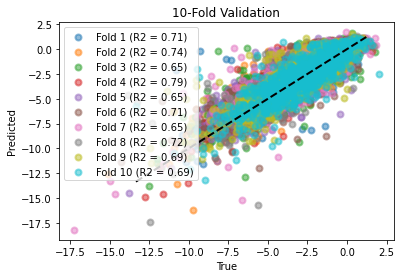

In [22]:
# 10 fold cross validation set results. Calculating pearson correlations.
from sklearn import model_selection, preprocessing, metrics, decomposition
import matplotlib.pyplot as plt
folds = 10
results = []
best_rmse_arr = []
bestrmsesum = 0
scores = []
true_val = []
pred_val = []
fig = plt.figure()
for fold in tqdm(range(folds)):
    val_losses = []
    train_losses = []
    mae_arr = []
    patience = 30
    trigger_times = 0
    the_last_loss = 100
    test_data = Molecule_data(root='data', dataset='test_data_set_fold_'+str(fold),y=None,smile_graph=None,smiles=None)
    
#     TRAIN_BATCH_SIZE = 40
    test_loader  = DataLoader(test_data,batch_size=TRAIN_BATCH_SIZE,shuffle=True)
    model = AttentionConvNet().to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate,
                             weight_decay=weight_decay)
    model_file_name = 'saved_models/model_' +  str(fold) +  '.model'
#     result_file_name = 'novelresult_' + str(fold) +  '.csv'
    checkpoint = torch.load(model_file_name, map_location=torch.device(device))
    model.load_state_dict(checkpoint)
#     model.load_state_dict(torch.load(model_file_name))
    
    test_loss,test_rmse, true, prediction = predicting(test_loader, model)
    
    best_ret = []
    bestrmsesum = bestrmsesum + test_rmse
    results.append(best_ret)
    best_rmse_arr.append(best_rmse)
    true_val.append(true)
    pred_val.append(prediction)
    score = metrics.r2_score(true, prediction)
    scores.append(score)
    print('Test R2: ', score)
    print('Test RMSE: ', test_rmse)
    plt.scatter(prediction, true, lw=2, alpha=0.5, 
                label='Fold %d (R2 = %0.2f)' % (fold+1,score))
plt.plot([min(prediction),max(true)], [min(prediction),max(true)], 
         linestyle='--', lw=2, color='black')
plt.xlabel('True')
plt.ylabel('Predicted')
plt.title('10-Fold Validation')
plt.legend()
plt.savefig('TestR2.png')
plt.show()
# avg = bestrmsesum/10
# print('10 fold avg is : ', avg)

In [23]:
# training whole dataset. first loading each fold model and train on whole dataset
folds = 10
results = []
best_rmse_arr = []
scores = []
true_val = []
pred_val = []
wholetrain_data = createTestData('Data_Prep','solubility_1.csv','solubility_1')
for fold in tqdm(range(folds)):
    wholetrain_loader  = DataLoader(wholetrain_data,batch_size=TRAIN_BATCH_SIZE,shuffle=True)
    model = AttentionConvNet().to(device)
    # model = define_model(trial).to(device)
    #optimizer_name = trial.suggest_categorical("optimizer", ["Adam", "RMSprop", "SGD"])
    # optimizer = torch.optim.Adam(model.parameters(), lr=.0023467,
    #                              weight_decay=.00095)
#     optimizer = torch.optim.Adam(model.parameters(), lr=0.007531829,
#                                    weight_decay=0.000252036)
#     model = AttentiveFP(in_channels=39, hidden_channels=200, out_channels=1,
#                     edge_dim=10, num_layers=2, num_timesteps=2,
#                     dropout=0.2).to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate,
                             weight_decay=weight_decay)
    val_losses = []
    train_losses = []
    mae_arr = []
    patience = 30
    trigger_times = 0
    the_last_loss = 100
    
    load_model_file_name = 'saved_models/model_' +  str(fold) +  '.model'
    model_file_name = 'saved_models/wholetrainmodel_' +  str(fold) +  '.model'
    result_file_name = 'wholetrainresult_' + str(fold) +  '.csv'
    checkpoint = torch.load(load_model_file_name, map_location=torch.device(device))
    model.load_state_dict(checkpoint)
    train_data = Molecule_data(root='data', dataset='train_data_set_fold_'+str(fold),y=None,smile_graph=None,smiles=None)
#     test_data = Molecule_data(root='data', dataset='test_data_set_fold_'+str(fold),y=None,smile_graph=None,smiles=None)
    
#     TRAIN_BATCH_SIZE = 64
    
#     train_loader   = DataLoader(train_data,batch_size=TRAIN_BATCH_SIZE,shuffle=True)
#     test_loader  = DataLoader(test_data,batch_size=TRAIN_BATCH_SIZE,shuffle=True)
#     model = AttentiveFP(in_channels=112, hidden_channels=279, out_channels=1,
#                     num_layers=3, num_timesteps=2,
#                     dropout=0.047352327938708194).to(device)
    best_ret = []
    
#     model = model.cuda(device)
#     optimizer = torch.optim.Adam(model.parameters(), lr=LR)
#     best_mae = 0.00
    
    for epoch in range(NUM_EPOCHS):
        train_loss,train_rmse=train(model, optimizer,train_loader)
#         test_loss,test_rmse = test(test_loader, model)
#         score = metrics.r2_score(true, prediction)
#         , true, prediction
        
        print(f'Epoch: {epoch:03d}, Loss: {train_rmse:.4f} '
          ) #f'Test: {test_rmse:.4f} 'f'score: {score:.4f} '   
        
        ret = [epoch,train_rmse]
        
        train_losses.append(train_rmse)
#         val_losses.append(test_rmse)
#         scores.append(score)
        # Early Stopping
        the_current_loss = train_rmse   #.item()
        best_ret.append(ret)
        if the_current_loss > the_last_loss:
            trigger_times += 1
            print('trigger times:', trigger_times)
    
            if trigger_times >= 200:   #patience
                print('Early stopping!\nStart to test process.')
                break
        else:
            ret = [epoch,train_rmse] #, ,test_rmse, score
            trigger_times = 0
            the_last_loss = the_current_loss
            best_rmse = the_current_loss
            
            torch.save(model.state_dict(), model_file_name)
        # Early stopping
#         the_current_loss = test_loss.item()
        
#         best_ret.append(ret)
        
#         if the_current_loss > the_last_loss:
#             trigger_times += 1
#             print('trigger times:', trigger_times)
            
#             if trigger_times >= patience:
#                 print('Early stopping!\nStart to test process.')
#                 break
#         else:
#             ret = [epoch,train_loss,test_loss.item()]
#             trigger_times = 0
#             best_mae = the_current_loss
#             the_last_loss = the_current_loss
            
#             torch.save(model.state_dict(), model_file_name)

    results.append(best_ret)
    best_rmse_arr.append(best_rmse)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 000, Loss: 1.0248 
Epoch: 001, Loss: 0.9867 
Epoch: 002, Loss: 0.9587 
Epoch: 003, Loss: 0.9366 
Epoch: 004, Loss: 0.9372 
trigger times: 1
Epoch: 005, Loss: 0.9655 
trigger times: 2
Epoch: 006, Loss: 0.9288 
Epoch: 007, Loss: 0.9332 
trigger times: 1
Epoch: 008, Loss: 0.9236 
Epoch: 009, Loss: 0.9144 
Epoch: 010, Loss: 0.9109 
Epoch: 011, Loss: 0.9059 
Epoch: 012, Loss: 0.8961 
Epoch: 013, Loss: 0.8940 
Epoch: 014, Loss: 0.9079 
trigger times: 1
Epoch: 015, Loss: 0.8923 
Epoch: 016, Loss: 0.8905 
Epoch: 017, Loss: 0.8732 
Epoch: 018, Loss: 0.8718 
Epoch: 019, Loss: 0.8884 
trigger times: 1
Epoch: 020, Loss: 0.8600 
Epoch: 021, Loss: 0.8779 
trigger times: 1
Epoch: 022, Loss: 0.8482 
Epoch: 023, Loss: 0.8579 
trigger times: 1
Epoch: 024, Loss: 0.8730 
trigger times: 2
Epoch: 025, Loss: 0.8553 
trigger times: 3
Epoch: 026, Loss: 0.8476 
Epoch: 027, Loss: 0.8596 
trigger times: 1
Epoch: 028, Loss: 0.8763 
trigger times: 2
Epoch: 029, Loss: 0.8532 
trigger times: 3
Epoch: 030, Loss

Epoch: 008, Loss: 0.9071 
Epoch: 009, Loss: 0.8991 
Epoch: 010, Loss: 0.9093 
trigger times: 1
Epoch: 011, Loss: 0.8914 
Epoch: 012, Loss: 0.8654 
Epoch: 013, Loss: 0.8626 
Epoch: 014, Loss: 0.8811 
trigger times: 1
Epoch: 015, Loss: 0.8564 
Epoch: 016, Loss: 0.8603 
trigger times: 1
Epoch: 017, Loss: 0.8563 
Epoch: 018, Loss: 0.8568 
trigger times: 1
Epoch: 019, Loss: 0.8473 
Epoch: 020, Loss: 0.8382 
Epoch: 021, Loss: 0.8312 
Epoch: 022, Loss: 0.8267 
Epoch: 023, Loss: 0.8400 
trigger times: 1
Epoch: 024, Loss: 0.8216 
Epoch: 025, Loss: 0.8092 
Epoch: 026, Loss: 0.8014 
Epoch: 027, Loss: 0.8028 
trigger times: 1
Epoch: 028, Loss: 0.7922 
Epoch: 029, Loss: 0.7788 
Epoch: 030, Loss: 0.7912 
trigger times: 1
Epoch: 031, Loss: 0.8232 
trigger times: 2
Epoch: 032, Loss: 0.8158 
trigger times: 3
Epoch: 033, Loss: 0.7812 
trigger times: 4
Epoch: 034, Loss: 0.7853 
trigger times: 5
Epoch: 035, Loss: 0.7622 
Epoch: 036, Loss: 0.7730 
trigger times: 1
Epoch: 037, Loss: 0.7815 
trigger times: 2

Epoch: 022, Loss: 0.8461 
trigger times: 2
Epoch: 023, Loss: 0.8298 
Epoch: 024, Loss: 0.8433 
trigger times: 1
Epoch: 025, Loss: 0.8429 
trigger times: 2
Epoch: 026, Loss: 0.8306 
trigger times: 3
Epoch: 027, Loss: 0.8001 
Epoch: 028, Loss: 0.7918 
Epoch: 029, Loss: 0.8230 
trigger times: 1
Epoch: 030, Loss: 0.8163 
trigger times: 2
Epoch: 031, Loss: 0.8133 
trigger times: 3
Epoch: 032, Loss: 0.8047 
trigger times: 4
Epoch: 033, Loss: 0.8109 
trigger times: 5
Epoch: 034, Loss: 0.8487 
trigger times: 6
Epoch: 035, Loss: 0.8219 
trigger times: 7
Epoch: 036, Loss: 0.8330 
trigger times: 8
Epoch: 037, Loss: 0.8249 
trigger times: 9
Epoch: 038, Loss: 0.7900 
Epoch: 039, Loss: 0.8120 
trigger times: 1
Epoch: 040, Loss: 0.7930 
trigger times: 2
Epoch: 041, Loss: 0.8174 
trigger times: 3
Epoch: 042, Loss: 0.8058 
trigger times: 4
Epoch: 043, Loss: 0.7928 
trigger times: 5
Epoch: 044, Loss: 0.7912 
trigger times: 6
Epoch: 045, Loss: 0.8024 
trigger times: 7
Epoch: 046, Loss: 0.7983 
trigger ti

Epoch: 020, Loss: 0.8859 
trigger times: 3
Epoch: 021, Loss: 0.8884 
trigger times: 4
Epoch: 022, Loss: 0.9086 
trigger times: 5
Epoch: 023, Loss: 0.9693 
trigger times: 6
Epoch: 024, Loss: 0.9917 
trigger times: 7
Epoch: 025, Loss: 1.0828 
trigger times: 8
Epoch: 026, Loss: 1.0463 
trigger times: 9
Epoch: 027, Loss: 0.9985 
trigger times: 10
Epoch: 028, Loss: 1.0012 
trigger times: 11
Epoch: 029, Loss: 0.9664 
trigger times: 12
Epoch: 030, Loss: 0.9512 
trigger times: 13
Epoch: 031, Loss: 0.9106 
trigger times: 14
Epoch: 032, Loss: 0.9082 
trigger times: 15
Epoch: 033, Loss: 0.8935 
trigger times: 16
Epoch: 034, Loss: 0.8701 
Epoch: 035, Loss: 0.8633 
Epoch: 036, Loss: 0.8544 
Epoch: 037, Loss: 0.8583 
trigger times: 1
Epoch: 038, Loss: 0.8645 
trigger times: 2
Epoch: 039, Loss: 0.8401 
Epoch: 040, Loss: 0.8426 
trigger times: 1
Epoch: 041, Loss: 0.8325 
Epoch: 042, Loss: 0.8298 
Epoch: 043, Loss: 0.8121 
Epoch: 044, Loss: 0.8431 
trigger times: 1
Epoch: 045, Loss: 0.8335 
trigger tim

Epoch: 031, Loss: 0.8014 
trigger times: 3
Epoch: 032, Loss: 0.7956 
Epoch: 033, Loss: 0.7809 
Epoch: 034, Loss: 0.8194 
trigger times: 1
Epoch: 035, Loss: 0.8015 
trigger times: 2
Epoch: 036, Loss: 0.8253 
trigger times: 3
Epoch: 037, Loss: 0.8059 
trigger times: 4
Epoch: 038, Loss: 0.7971 
trigger times: 5
Epoch: 039, Loss: 0.8013 
trigger times: 6
Epoch: 040, Loss: 0.7790 
Epoch: 041, Loss: 0.7809 
trigger times: 1
Epoch: 042, Loss: 0.7606 
Epoch: 043, Loss: 0.7543 
Epoch: 044, Loss: 0.7495 
Epoch: 045, Loss: 0.7902 
trigger times: 1
Epoch: 046, Loss: 0.7815 
trigger times: 2
Epoch: 047, Loss: 0.7820 
trigger times: 3
Epoch: 048, Loss: 0.7519 
trigger times: 4
Epoch: 049, Loss: 0.7343 
Epoch: 050, Loss: 0.7405 
trigger times: 1
Epoch: 051, Loss: 0.7406 
trigger times: 2
Epoch: 052, Loss: 0.7408 
trigger times: 3
Epoch: 053, Loss: 0.7270 
Epoch: 054, Loss: 0.7150 
Epoch: 055, Loss: 0.7255 
trigger times: 1
Epoch: 056, Loss: 0.7036 
Epoch: 057, Loss: 0.6962 
Epoch: 058, Loss: 0.7151 


Epoch: 043, Loss: 0.8111 
trigger times: 8
Epoch: 044, Loss: 0.8173 
trigger times: 9
Epoch: 045, Loss: 0.7748 
Epoch: 046, Loss: 0.7643 
Epoch: 047, Loss: 0.7909 
trigger times: 1
Epoch: 048, Loss: 0.7725 
trigger times: 2
Epoch: 049, Loss: 0.7480 
Epoch: 050, Loss: 0.7734 
trigger times: 1
Epoch: 051, Loss: 0.7515 
trigger times: 2
Epoch: 052, Loss: 0.7670 
trigger times: 3
Epoch: 053, Loss: 0.7702 
trigger times: 4
Epoch: 054, Loss: 0.7901 
trigger times: 5
Epoch: 055, Loss: 0.7865 
trigger times: 6
Epoch: 056, Loss: 0.7563 
trigger times: 7
Epoch: 057, Loss: 0.7476 
Epoch: 058, Loss: 0.7519 
trigger times: 1
Epoch: 059, Loss: 0.7741 
trigger times: 2
Epoch: 060, Loss: 0.7676 
trigger times: 3
Epoch: 061, Loss: 0.7595 
trigger times: 4
Epoch: 062, Loss: 0.7676 
trigger times: 5
Epoch: 063, Loss: 0.7500 
trigger times: 6
Epoch: 064, Loss: 0.7653 
trigger times: 7
Epoch: 065, Loss: 0.7562 
trigger times: 8
Epoch: 066, Loss: 0.7421 
Epoch: 067, Loss: 0.7552 
trigger times: 1
Epoch: 068

Epoch: 055, Loss: 0.7896 
trigger times: 6
Epoch: 056, Loss: 0.8200 
trigger times: 7
Epoch: 057, Loss: 0.8005 
trigger times: 8
Epoch: 058, Loss: 0.8014 
trigger times: 9
Epoch: 059, Loss: 0.7717 
Epoch: 060, Loss: 0.7778 
trigger times: 1
Epoch: 061, Loss: 0.7978 
trigger times: 2
Epoch: 062, Loss: 0.7747 
trigger times: 3
Epoch: 063, Loss: 0.7632 
Epoch: 064, Loss: 0.7574 
Epoch: 065, Loss: 0.7573 
Epoch: 066, Loss: 0.7742 
trigger times: 1
Epoch: 067, Loss: 0.7680 
trigger times: 2
Epoch: 068, Loss: 0.7495 
Epoch: 069, Loss: 0.7737 
trigger times: 1
Epoch: 070, Loss: 0.7839 
trigger times: 2
Epoch: 071, Loss: 0.8027 
trigger times: 3
Epoch: 072, Loss: 0.7894 
trigger times: 4
Epoch: 073, Loss: 0.7872 
trigger times: 5
Epoch: 074, Loss: 0.7671 
trigger times: 6
Epoch: 075, Loss: 0.7656 
trigger times: 7
Epoch: 076, Loss: 0.8038 
trigger times: 8
Epoch: 077, Loss: 0.7625 
trigger times: 9
Epoch: 078, Loss: 0.7441 
Epoch: 079, Loss: 0.7452 
trigger times: 1
Epoch: 080, Loss: 0.7489 
t

Epoch: 057, Loss: 1.0484 
trigger times: 40
Epoch: 058, Loss: 1.0345 
trigger times: 41
Epoch: 059, Loss: 1.0554 
trigger times: 42
Epoch: 060, Loss: 1.0374 
trigger times: 43
Epoch: 061, Loss: 1.0436 
trigger times: 44
Epoch: 062, Loss: 1.0324 
trigger times: 45
Epoch: 063, Loss: 1.0382 
trigger times: 46
Epoch: 064, Loss: 1.0251 
trigger times: 47
Epoch: 065, Loss: 1.0197 
trigger times: 48
Epoch: 066, Loss: 1.0091 
trigger times: 49
Epoch: 067, Loss: 1.0368 
trigger times: 50
Epoch: 068, Loss: 1.0231 
trigger times: 51
Epoch: 069, Loss: 1.0088 
trigger times: 52
Epoch: 070, Loss: 1.0062 
trigger times: 53
Epoch: 071, Loss: 1.0084 
trigger times: 54
Epoch: 072, Loss: 1.0142 
trigger times: 55
Epoch: 073, Loss: 0.9952 
trigger times: 56
Epoch: 074, Loss: 0.9988 
trigger times: 57
Epoch: 075, Loss: 1.0087 
trigger times: 58
Epoch: 076, Loss: 1.0212 
trigger times: 59
Epoch: 077, Loss: 1.0441 
trigger times: 60
Epoch: 078, Loss: 1.0365 
trigger times: 61
Epoch: 079, Loss: 1.0241 
trigge

Epoch: 046, Loss: 0.9343 
trigger times: 1
Epoch: 047, Loss: 0.9204 
Epoch: 048, Loss: 0.9250 
trigger times: 1
Epoch: 049, Loss: 0.9164 
Epoch: 050, Loss: 0.9237 
trigger times: 1
Epoch: 051, Loss: 0.8960 
Epoch: 052, Loss: 0.9379 
trigger times: 1
Epoch: 053, Loss: 0.9215 
trigger times: 2
Epoch: 054, Loss: 0.9209 
trigger times: 3
Epoch: 055, Loss: 0.8991 
trigger times: 4
Epoch: 056, Loss: 0.9031 
trigger times: 5
Epoch: 057, Loss: 0.8957 
Epoch: 058, Loss: 0.9016 
trigger times: 1
Epoch: 059, Loss: 0.9032 
trigger times: 2
Epoch: 060, Loss: 0.8941 
Epoch: 061, Loss: 0.8934 
Epoch: 062, Loss: 0.8978 
trigger times: 1
Epoch: 063, Loss: 0.8935 
trigger times: 2
Epoch: 064, Loss: 0.8764 
Epoch: 065, Loss: 0.8874 
trigger times: 1
Epoch: 066, Loss: 0.8932 
trigger times: 2
Epoch: 067, Loss: 0.8872 
trigger times: 3
Epoch: 068, Loss: 0.8782 
trigger times: 4
Epoch: 069, Loss: 0.8958 
trigger times: 5
Epoch: 070, Loss: 0.8767 
trigger times: 6
Epoch: 071, Loss: 0.8734 
Epoch: 072, Loss: 

Epoch: 054, Loss: 0.7965 
Epoch: 055, Loss: 0.7872 
Epoch: 056, Loss: 0.7837 
Epoch: 057, Loss: 0.7808 
Epoch: 058, Loss: 0.7944 
trigger times: 1
Epoch: 059, Loss: 0.7732 
Epoch: 060, Loss: 0.7891 
trigger times: 1
Epoch: 061, Loss: 0.7856 
trigger times: 2
Epoch: 062, Loss: 0.7776 
trigger times: 3
Epoch: 063, Loss: 0.7744 
trigger times: 4
Epoch: 064, Loss: 0.7997 
trigger times: 5
Epoch: 065, Loss: 0.7998 
trigger times: 6
Epoch: 066, Loss: 0.8073 
trigger times: 7
Epoch: 067, Loss: 0.7952 
trigger times: 8
Epoch: 068, Loss: 0.7954 
trigger times: 9
Epoch: 069, Loss: 0.7700 
Epoch: 070, Loss: 0.7663 
Epoch: 071, Loss: 0.7510 
Epoch: 072, Loss: 0.7514 
trigger times: 1
Epoch: 073, Loss: 0.7613 
trigger times: 2
Epoch: 074, Loss: 0.7459 
Epoch: 075, Loss: 0.7762 
trigger times: 1
Epoch: 076, Loss: 0.7587 
trigger times: 2
Epoch: 077, Loss: 0.7501 
trigger times: 3
Epoch: 078, Loss: 0.7574 
trigger times: 4
Epoch: 079, Loss: 0.7593 
trigger times: 5
Epoch: 080, Loss: 0.7740 
trigger t

In [24]:
noveltest_data = createTestData('New_fold','testset_novel.csv','testset_novel')
# noveltest_data = Molecule_data(root='data', dataset='testset_novel',y=None,smile_graph=None,smiles=None)
# noveltest_loader  = DataLoader(noveltest_data,batch_size=TRAIN_BATCH_SIZE,shuffle=True)
#     model = AttentiveFP(in_channels=112, hidden_channels=279, out_channels=1,

In [29]:
# test novel dataset on whole trained model.
from sklearn import model_selection, preprocessing, metrics, decomposition
import matplotlib.pyplot as plt
folds = 10
results = []
best_rmse_arr = []
bestrmsesum = 0
scores = []
true_val = []
pred_val = []
# fig = plt.figure()
# for fold in tqdm(range(folds)):
# val_losses = []
# train_losses = []
# mae_arr = []
# patience = 30
# trigger_times = 0
# the_last_loss = 100
for fold in tqdm(range(folds)):
    noveltest_loader  = DataLoader(noveltest_data,batch_size=TRAIN_BATCH_SIZE,shuffle=True)
    model = AttentionConvNet().to(device)
    # model = define_model(trial).to(device)
    #optimizer_name = trial.suggest_categorical("optimizer", ["Adam", "RMSprop", "SGD"])
    # optimizer = torch.optim.Adam(model.parameters(), lr=.0023467,
    #                              weight_decay=.00095)
#     optimizer = torch.optim.Adam(model.parameters(), lr=0.007531829,
#                                    weight_decay=0.000252036)
#     model = AttentiveFP(in_channels=39, hidden_channels=200, out_channels=1,
#                     edge_dim=10, num_layers=2, num_timesteps=2,
#                     dropout=0.2).to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate,
                             weight_decay=weight_decay)
    val_losses = []
    train_losses = []
    mae_arr = []
    patience = 30
    trigger_times = 0
    the_last_loss = 100
    
    model_file_name = 'saved_models/wholetrainmodel_' +  str(fold) +  '.model'
    checkpoint = torch.load(model_file_name, map_location=torch.device(device))
    model.load_state_dict(checkpoint)
#     train_data = Molecule_data(root='data', dataset='train_data_set_fold_'+str(fold),y=None,smile_graph=None,smiles=None)
    test_loss,test_rmse, true, prediction = predicting(noveltest_loader, model)

    best_ret = []
    bestrmsesum = bestrmsesum + test_rmse
    results.append(best_ret)
    best_rmse_arr.append(best_rmse)
    true_val.append(true)
    pred_val.append(prediction)
    score = metrics.r2_score(true, prediction)
    scores.append(score)
    print('Test R2: ', score)
    print('Test RMSE:', test_rmse)

  0%|          | 0/10 [00:00<?, ?it/s]

total_labels :  torch.Size([62, 1])
total_preds :  torch.Size([62, 1])
Test R2:  0.20318330011401697
Test RMSE: 0.7926696062758052
total_labels :  torch.Size([62, 1])
total_preds :  torch.Size([62, 1])
Test R2:  -0.15691435090603356
Test RMSE: 0.9551324809390132
total_labels :  torch.Size([62, 1])
total_preds :  torch.Size([62, 1])
Test R2:  -0.5691367963920393
Test RMSE: 1.1123549506106722
total_labels :  torch.Size([62, 1])
total_preds :  torch.Size([62, 1])
Test R2:  0.055690388196069085
Test RMSE: 0.8629193129806673
total_labels :  torch.Size([62, 1])
total_preds :  torch.Size([62, 1])
Test R2:  -0.07773297018962833
Test RMSE: 0.9218676291995458
total_labels :  torch.Size([62, 1])
total_preds :  torch.Size([62, 1])
Test R2:  -0.22415382506127624
Test RMSE: 0.9824964369886404
total_labels :  torch.Size([62, 1])
total_preds :  torch.Size([62, 1])
Test R2:  0.0017910350392539298
Test RMSE: 0.8872044783173919
total_labels :  torch.Size([62, 1])
total_preds :  torch.Size([62, 1])
Test R